In [1]:
# Import necessary libraries
from __future__ import division, print_function, unicode_literals

import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

import tensorflow as tf
import numpy as np
from functools import partial
import glob, os
import pickle
import copy

In [111]:
# User inputs
data_train_len = 20  # Number of training data files
data_name = 'Burgers_Eqn_exp21'  # Prefix of data files
folder_name = 'Burgers_exp21f/'  # Folder to be created for saved output

In [112]:
# Find the model with lowest validation error
import math

def BestErrorFile(folder_name):

    filename_best = ''
    best_error = 10**6

    current_dir = os.getcwd()
    os.chdir("./" + folder_name)
    for file in glob.glob("*.pkl"):
        with open(file, 'rb') as f:
            params = pickle.load(f)
            if not math.isnan(params['minRegTest']):
                if params['minRegTest'] < best_error:
                    filename_best = file
                    best_error = params['minRegTest']
    os.chdir(current_dir)

    return filename_best

pkl_file = folder_name + BestErrorFile(folder_name)

with open(pkl_file, 'rb') as f:
     params = pickle.load(f)

params['model_restore_path'] = params['model_path']
print(params['minRegTest'])


0.0008660905295982957


In [60]:
# Create numpy arrays with data
data_train = np.loadtxt(('./data/%s_train1_x.csv' % (params['data_name'])), delimiter=',', dtype=np.float32)
data_val = np.loadtxt(('./data/%s_val_x.csv' % (params['data_name'])), delimiter=',', dtype=np.float32)

print('done')

KeyboardInterrupt: 

In [ ]:
import helperfns_convnet

max_shifts_to_stack = helperfns_convnet.num_shifts_in_stack(params)
data_val_tensor = helperfns_convnet.stack_data(data_val, max_shifts_to_stack, params['val_len_time'])
data_train_tensor = helperfns_convnet.stack_data(data_train, max_shifts_to_stack, params['train_len_time'][0])

In [132]:
# Run a session to get encoded (initial condition), prediction (final time), loss
tf.reset_default_graph()

with tf.Session() as sess:
    saver = tf.train.import_meta_graph(params['model_path']+'.meta')
    saver.restore(sess, params['model_path'])
    
    
    train_encoded, train_outputs, train_loss = sess.run(["encoder/v_k/Exp:0","decoder_outer_151/outputs/BiasAdd:0","loss:0"], feed_dict={"x:0": data_train_tensor})   
    val_encoded, val_outputs, val_loss = sess.run(["encoder/v_k/Exp:0","decoder_outer_151/outputs/BiasAdd:0","loss:0"], feed_dict={"x:0": data_val_tensor}) 
    
    mu_pred = sess.run(tf.get_default_graph().get_tensor_by_name("dynamics/mu:0"))
    print(train_loss)
    print(val_loss)
    print(mu_pred)
     
    

INFO:tensorflow:Restoring parameters from ./Burgers_exp21f/Burgers_Eqn_exp21_2019_03_01_22_35_42_301187_model.ckpt
[0.00089002]
[0.00085706]
[0.19034417]


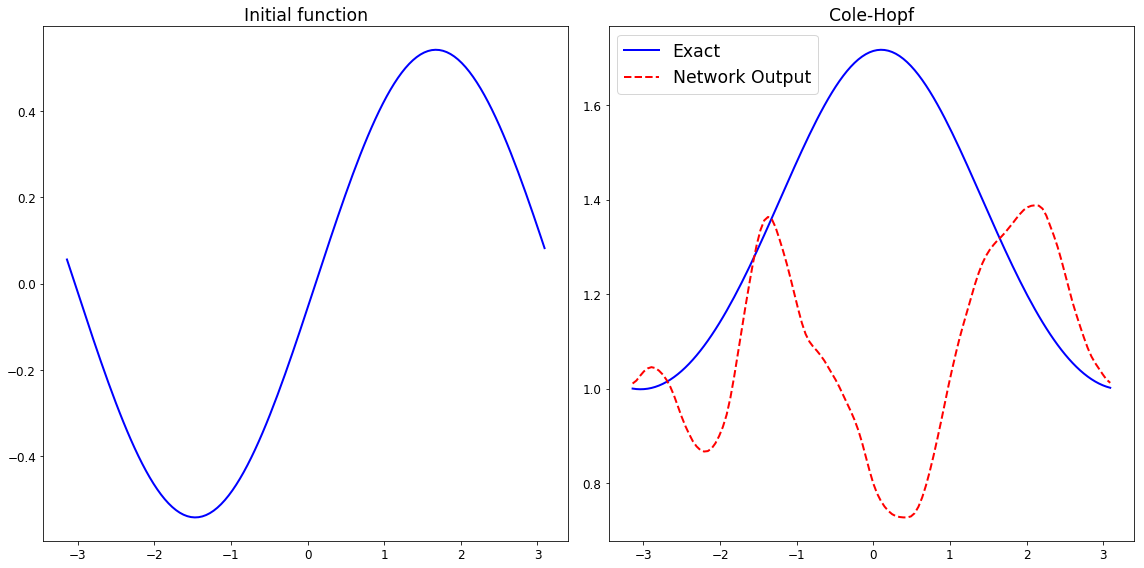

In [138]:
# Plot Cole-Hopf
from scipy.integrate import cumtrapz

# Inputs
eps = 1
mu = 1
data = 'train'  # 'train', 'val', or 'test'
ind = 4    # index of initial condition

if data == 'train':
    encoded = train_encoded
    data_tensor = data_train_tensor
elif data == 'val':
    encoded = val_encoded
    data_tensor = data_val_tensor
else:
    encoded = train_encoded
    data_tensor = data_train_tensor

x_pts = np.linspace(-np.pi,np.pi,129)
x_pts = x_pts[0:128]  
    
f = data_tensor[0,ind,:]
int_vec = cumtrapz(f, x_pts, initial=0)
v = np.exp(-eps*int_vec/(2*mu))


f, (ax1, ax2) = plt.subplots(1,2,figsize=(16,8))
ax1.plot(x_pts, data_tensor[0,ind,:], "b-", linewidth=2)
ax1.set_title('Initial function', fontsize='xx-large')
ax2.plot(x_pts, v, "b-", linewidth=2)
ax2.plot(x_pts, encoded[ind,:], "r--", linewidth=2)
ax2.set_title('Cole-Hopf', fontsize='xx-large')
ax2.legend(['Exact','Network Output'], loc=2, fontsize='xx-large')
    
plt.tight_layout()
plt.show()
    
    

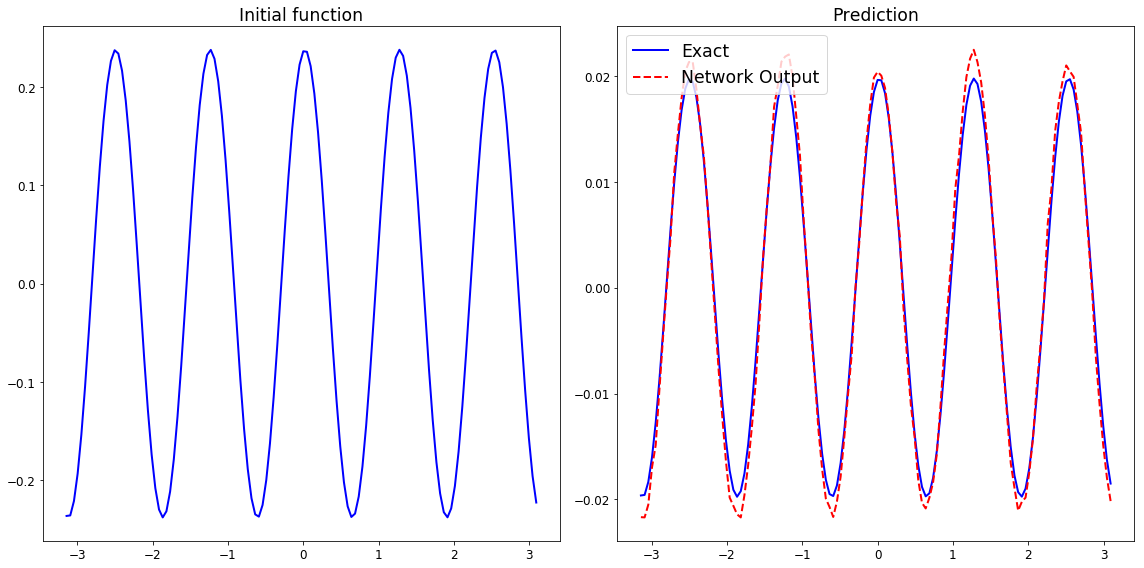

In [142]:
# Plot prediction 

# Inputs
eps = 1
mu = 1
data = 'train'  # 'train', 'val', or 'test'
ind = 13    # index of initial condition

if data == 'train':
    outputs = train_outputs
    data_tensor = data_train_tensor
elif data == 'val':
    outputs = val_outputs
    data_tensor = data_val_tensor
else:
    outputs = train_outputs
    data_tensor = data_train_tensor


x_pts = np.linspace(-np.pi,np.pi,129)
x_pts = x_pts[0:128]
    
f, (ax1, ax2) = plt.subplots(1,2,figsize=(16,8))
ax1.plot(x_pts, data_train_tensor[0,ind,:], "b-", linewidth=2)
ax1.set_title('Initial function', fontsize='xx-large')
ax2.plot(x_pts, data_train_tensor[50,ind,:], "b-", linewidth=2)
ax2.plot(x_pts, outputs[ind,:], "r--", linewidth=2)
ax2.set_title('Prediction', fontsize='xx-large')
ax2.legend(['Exact','Network Output'], loc=2, fontsize='xx-large')
    
plt.tight_layout()
plt.show()

In [107]:
# List all graph operations (if necessary to do more post processing)
tf.reset_default_graph()

with tf.Session() as sess:
    saver = tf.train.import_meta_graph(params['model_path']+'.meta')
    saver.restore(sess, params['model_path'])
     
    graph = tf.get_default_graph()
    for op in graph.get_operations():
        print(op.name)
        
    
    

INFO:tensorflow:Restoring parameters from ./Burgers_exp21a/Burgers_Eqn_exp21_2019_02_18_17_40_42_475578_model.ckpt
Placeholder
strided_slice/stack
strided_slice/stack_1
strided_slice/stack_2
strided_slice
Squeeze
Identity
encoder/add/y
encoder/add
encoder/log_uk
encoder/log_uk_reshaped/shape
encoder/log_uk_reshaped
encoder/hidden1_encode/kernel/Initializer/truncated_normal/shape
encoder/hidden1_encode/kernel/Initializer/truncated_normal/mean
encoder/hidden1_encode/kernel/Initializer/truncated_normal/stddev
encoder/hidden1_encode/kernel/Initializer/truncated_normal/TruncatedNormal
encoder/hidden1_encode/kernel/Initializer/truncated_normal/mul
encoder/hidden1_encode/kernel/Initializer/truncated_normal
encoder/hidden1_encode/kernel
encoder/hidden1_encode/kernel/Assign
encoder/hidden1_encode/kernel/read
encoder/hidden1_encode/kernel/Regularizer/l2_regularizer/scale
encoder/hidden1_encode/kernel/Regularizer/l2_regularizer/L2Loss
encoder/hidden1_encode/kernel/Regularizer/l2_regularizer
encod

decoder_outer_5/log_vkplus1_reshaped
decoder_outer_5/hidden1_decode/convolution/Shape
decoder_outer_5/hidden1_decode/convolution/dilation_rate
decoder_outer_5/hidden1_decode/convolution/ExpandDims/dim
decoder_outer_5/hidden1_decode/convolution/ExpandDims
decoder_outer_5/hidden1_decode/convolution/ExpandDims_1/dim
decoder_outer_5/hidden1_decode/convolution/ExpandDims_1
decoder_outer_5/hidden1_decode/convolution/Conv2D
decoder_outer_5/hidden1_decode/convolution/Squeeze
decoder_outer_5/hidden1_decode/BiasAdd
decoder_outer_5/hidden1_decode/Relu
decoder_outer_5/mul
decoder_outer_5/hidden2_decode/reduction_indices
decoder_outer_5/hidden2_decode
decoder_outer_5/outputs/MatMul
decoder_outer_5/outputs/BiasAdd
Identity_63
Const_58
decoder_inner_6/MatMul
Identity_64
decoder_outer_6/log_vkplus1
decoder_outer_6/log_vkplus1_reshaped/shape
decoder_outer_6/log_vkplus1_reshaped
decoder_outer_6/hidden1_decode/convolution/Shape
decoder_outer_6/hidden1_decode/convolution/dilation_rate
decoder_outer_6/hidd

decoder_outer_81/hidden1_decode/convolution/Conv2D
decoder_outer_81/hidden1_decode/convolution/Squeeze
decoder_outer_81/hidden1_decode/BiasAdd
decoder_outer_81/hidden1_decode/Relu
decoder_outer_81/mul
decoder_outer_81/hidden2_decode/reduction_indices
decoder_outer_81/hidden2_decode
decoder_outer_81/outputs/MatMul
decoder_outer_81/outputs/BiasAdd
Identity_185
decoder_outer_82/log_vkplus1
decoder_outer_82/log_vkplus1_reshaped/shape
decoder_outer_82/log_vkplus1_reshaped
decoder_outer_82/hidden1_decode/convolution/Shape
decoder_outer_82/hidden1_decode/convolution/dilation_rate
decoder_outer_82/hidden1_decode/convolution/ExpandDims/dim
decoder_outer_82/hidden1_decode/convolution/ExpandDims
decoder_outer_82/hidden1_decode/convolution/ExpandDims_1/dim
decoder_outer_82/hidden1_decode/convolution/ExpandDims_1
decoder_outer_82/hidden1_decode/convolution/Conv2D
decoder_outer_82/hidden1_decode/convolution/Squeeze
decoder_outer_82/hidden1_decode/BiasAdd
decoder_outer_82/hidden1_decode/Relu
decoder_

Const_153
decoder_inner_101/MatMul
Identity_305
decoder_outer_152/log_vkplus1
decoder_outer_152/log_vkplus1_reshaped/shape
decoder_outer_152/log_vkplus1_reshaped
decoder_outer_152/hidden1_decode/convolution/Shape
decoder_outer_152/hidden1_decode/convolution/dilation_rate
decoder_outer_152/hidden1_decode/convolution/ExpandDims/dim
decoder_outer_152/hidden1_decode/convolution/ExpandDims
decoder_outer_152/hidden1_decode/convolution/ExpandDims_1/dim
decoder_outer_152/hidden1_decode/convolution/ExpandDims_1
decoder_outer_152/hidden1_decode/convolution/Conv2D
decoder_outer_152/hidden1_decode/convolution/Squeeze
decoder_outer_152/hidden1_decode/BiasAdd
decoder_outer_152/hidden1_decode/Relu
decoder_outer_152/mul
decoder_outer_152/hidden2_decode/reduction_indices
decoder_outer_152/hidden2_decode
decoder_outer_152/outputs/MatMul
decoder_outer_152/outputs/BiasAdd
MatMul_50
zeros
strided_slice_51/stack
strided_slice_51/stack_1
strided_slice_51/stack_2
strided_slice_51
Squeeze_51
Square
Mean/reduct

Mean_190/reduction_indices
Mean_190
Rank_95
range_95/start
range_95/delta
range_95
Mean_191
truediv_47
mul_47/x
mul_47
add_95
strided_slice_147/stack
strided_slice_147/stack_1
strided_slice_147/stack_2
strided_slice_147
Squeeze_147
Square_96
Mean_192/reduction_indices
Mean_192
Rank_96
range_96/start
range_96/delta
range_96
Mean_193
add_96/y
add_96
strided_slice_148/stack
strided_slice_148/stack_1
strided_slice_148/stack_2
strided_slice_148
Squeeze_148
sub_48
Square_97
Mean_194/reduction_indices
Mean_194
Rank_97
range_97/start
range_97/delta
range_97
Mean_195
truediv_48
mul_48/x
mul_48
add_97
strided_slice_149/stack
strided_slice_149/stack_1
strided_slice_149/stack_2
strided_slice_149
Squeeze_149
Square_98
Mean_196/reduction_indices
Mean_196
Rank_98
range_98/start
range_98/delta
range_98
Mean_197
add_98/y
add_98
strided_slice_150/stack
strided_slice_150/stack_1
strided_slice_150/stack_2
strided_slice_150
Squeeze_150
sub_49
Square_99
Mean_198/reduction_indices
Mean_198
Rank_99
range_99/s

sub_94
Square_189
Mean_378/reduction_indices
Mean_378
Rank_189
range_189/start
range_189/delta
range_189
Mean_379
truediv_94
mul_94/x
mul_94
add_189
strided_slice_241/stack
strided_slice_241/stack_1
strided_slice_241/stack_2
strided_slice_241
Squeeze_241
Square_190
Mean_380/reduction_indices
Mean_380
Rank_190
range_190/start
range_190/delta
range_190
Mean_381
add_190/y
add_190
strided_slice_242/stack
strided_slice_242/stack_1
strided_slice_242/stack_2
strided_slice_242
Squeeze_242
sub_95
Square_191
Mean_382/reduction_indices
Mean_382
Rank_191
range_191/start
range_191/delta
range_191
Mean_383
truediv_95
mul_95/x
mul_95
add_191
strided_slice_243/stack
strided_slice_243/stack_1
strided_slice_243/stack_2
strided_slice_243
Squeeze_243
Square_192
Mean_384/reduction_indices
Mean_384
Rank_192
range_192/start
range_192/delta
range_192
Mean_385
add_192/y
add_192
strided_slice_244/stack
strided_slice_244/stack_1
strided_slice_244/stack_2
strided_slice_244
Squeeze_244
sub_96
Square_193
Mean_386/r

mul_169/x
mul_169
add_339
Square_340
Mean_680/reduction_indices
Mean_680
Const_242
Mean_681
add_340/y
add_340
MatMul_140
MatMul_141
sub_170
Square_341
Mean_682/reduction_indices
Mean_682
Const_243
Mean_683
truediv_170
mul_170/x
mul_170
add_341
Square_342
Mean_684/reduction_indices
Mean_684
Const_244
Mean_685
add_342/y
add_342
MatMul_142
MatMul_143
sub_171
Square_343
Mean_686/reduction_indices
Mean_686
Const_245
Mean_687
truediv_171
mul_171/x
mul_171
add_343
Square_344
Mean_688/reduction_indices
Mean_688
Const_246
Mean_689
add_344/y
add_344
MatMul_144
MatMul_145
sub_172
Square_345
Mean_690/reduction_indices
Mean_690
Const_247
Mean_691
truediv_172
mul_172/x
mul_172
add_345
Square_346
Mean_692/reduction_indices
Mean_692
Const_248
Mean_693
add_346/y
add_346
MatMul_146
MatMul_147
sub_173
Square_347
Mean_694/reduction_indices
Mean_694
Const_249
Mean_695
truediv_173
mul_173/x
mul_173
add_347
Square_348
Mean_696/reduction_indices
Mean_696
Const_250
Mean_697
add_348/y
add_348
MatMul_148
MatMul_

Square_484
Mean_968/reduction_indices
Mean_968
Rank_332
range_332/start
range_332/delta
range_332
Mean_969
add_484/y
add_484
strided_slice_334/stack
strided_slice_334/stack_1
strided_slice_334/stack_2
strided_slice_334
Squeeze_384
sub_242
Square_485
Mean_970/reduction_indices
Mean_970
Rank_333
range_333/start
range_333/delta
range_333
Mean_971
truediv_242
mul_242/x
mul_242
add_485
strided_slice_335/stack
strided_slice_335/stack_1
strided_slice_335/stack_2
strided_slice_335
Squeeze_385
Square_486
Mean_972/reduction_indices
Mean_972
Rank_334
range_334/start
range_334/delta
range_334
Mean_973
add_486/y
add_486
strided_slice_336/stack
strided_slice_336/stack_1
strided_slice_336/stack_2
strided_slice_336
Squeeze_386
sub_243
Square_487
Mean_974/reduction_indices
Mean_974
Rank_335
range_335/start
range_335/delta
range_335
Mean_975
truediv_243
mul_243/x
mul_243
add_487
strided_slice_337/stack
strided_slice_337/stack_1
strided_slice_337/stack_2
strided_slice_337
Squeeze_387
Square_488
Mean_976/

gradients/Mean_1003_grad/range/start
gradients/Mean_1003_grad/range/delta
gradients/Mean_1003_grad/range
gradients/Mean_1003_grad/Fill/value
gradients/Mean_1003_grad/Fill
gradients/Mean_1003_grad/DynamicStitch
gradients/Mean_1003_grad/Maximum/y
gradients/Mean_1003_grad/Maximum
gradients/Mean_1003_grad/floordiv
gradients/Mean_1003_grad/Reshape
gradients/Mean_1003_grad/Tile
gradients/Mean_1003_grad/Shape_2
gradients/Mean_1003_grad/Shape_3
gradients/Mean_1003_grad/Const
gradients/Mean_1003_grad/Prod
gradients/Mean_1003_grad/Const_1
gradients/Mean_1003_grad/Prod_1
gradients/Mean_1003_grad/Maximum_1/y
gradients/Mean_1003_grad/Maximum_1
gradients/Mean_1003_grad/floordiv_1
gradients/Mean_1003_grad/Cast
gradients/Mean_1003_grad/truediv
gradients/add_95_grad/Shape
gradients/add_95_grad/Shape_1
gradients/add_95_grad/BroadcastGradientArgs
gradients/add_95_grad/Sum
gradients/add_95_grad/Reshape
gradients/add_95_grad/Sum_1
gradients/add_95_grad/Reshape_1
gradients/add_95_grad/tuple/group_deps
gradi

gradients/Mean_600_grad/Shape
gradients/Mean_600_grad/Size
gradients/Mean_600_grad/add
gradients/Mean_600_grad/mod
gradients/Mean_600_grad/Shape_1
gradients/Mean_600_grad/range/start
gradients/Mean_600_grad/range/delta
gradients/Mean_600_grad/range
gradients/Mean_600_grad/Fill/value
gradients/Mean_600_grad/Fill
gradients/Mean_600_grad/DynamicStitch
gradients/Mean_600_grad/Maximum/y
gradients/Mean_600_grad/Maximum
gradients/Mean_600_grad/floordiv
gradients/Mean_600_grad/Reshape
gradients/Mean_600_grad/Tile
gradients/Mean_600_grad/Shape_2
gradients/Mean_600_grad/Shape_3
gradients/Mean_600_grad/Const
gradients/Mean_600_grad/Prod
gradients/Mean_600_grad/Const_1
gradients/Mean_600_grad/Prod_1
gradients/Mean_600_grad/Maximum_1/y
gradients/Mean_600_grad/Maximum_1
gradients/Mean_600_grad/floordiv_1
gradients/Mean_600_grad/Cast
gradients/Mean_600_grad/truediv
gradients/add_387_grad/Shape
gradients/add_387_grad/Shape_1
gradients/add_387_grad/BroadcastGradientArgs
gradients/add_387_grad/Sum
gradi

gradients/Mean_990_grad/Shape_1
gradients/Mean_990_grad/range/start
gradients/Mean_990_grad/range/delta
gradients/Mean_990_grad/range
gradients/Mean_990_grad/Fill/value
gradients/Mean_990_grad/Fill
gradients/Mean_990_grad/DynamicStitch
gradients/Mean_990_grad/Maximum/y
gradients/Mean_990_grad/Maximum
gradients/Mean_990_grad/floordiv
gradients/Mean_990_grad/Reshape
gradients/Mean_990_grad/Tile
gradients/Mean_990_grad/Shape_2
gradients/Mean_990_grad/Shape_3
gradients/Mean_990_grad/Const
gradients/Mean_990_grad/Prod
gradients/Mean_990_grad/Const_1
gradients/Mean_990_grad/Prod_1
gradients/Mean_990_grad/Maximum_1/y
gradients/Mean_990_grad/Maximum_1
gradients/Mean_990_grad/floordiv_1
gradients/Mean_990_grad/Cast
gradients/Mean_990_grad/truediv
gradients/Square_497_grad/mul/x
gradients/Square_497_grad/mul
gradients/Square_497_grad/mul_1
gradients/sub_249_grad/Shape
gradients/sub_249_grad/Shape_1
gradients/sub_249_grad/BroadcastGradientArgs
gradients/sub_249_grad/Sum
gradients/sub_249_grad/Res

gradients/Mean_569_grad/Prod
gradients/Mean_569_grad/Const_1
gradients/Mean_569_grad/Prod_1
gradients/Mean_569_grad/Maximum_1/y
gradients/Mean_569_grad/Maximum_1
gradients/Mean_569_grad/floordiv_1
gradients/Mean_569_grad/Cast
gradients/Mean_569_grad/truediv
gradients/Square_287_grad/mul/x
gradients/Square_287_grad/mul
gradients/Square_287_grad/mul_1
gradients/sub_144_grad/Shape
gradients/sub_144_grad/Shape_1
gradients/sub_144_grad/BroadcastGradientArgs
gradients/sub_144_grad/Sum
gradients/sub_144_grad/Reshape
gradients/sub_144_grad/Sum_1
gradients/sub_144_grad/Neg
gradients/sub_144_grad/Reshape_1
gradients/sub_144_grad/tuple/group_deps
gradients/sub_144_grad/tuple/control_dependency
gradients/sub_144_grad/tuple/control_dependency_1
gradients/Mean_580_grad/Shape
gradients/Mean_580_grad/Size
gradients/Mean_580_grad/add
gradients/Mean_580_grad/mod
gradients/Mean_580_grad/Shape_1
gradients/Mean_580_grad/range/start
gradients/Mean_580_grad/range/delta
gradients/Mean_580_grad/range
gradients

gradients/Mean_561_grad/Maximum_1
gradients/Mean_561_grad/floordiv_1
gradients/Mean_561_grad/Cast
gradients/Mean_561_grad/truediv
gradients/Square_283_grad/mul/x
gradients/Square_283_grad/mul
gradients/Square_283_grad/mul_1
gradients/sub_142_grad/Shape
gradients/sub_142_grad/Shape_1
gradients/sub_142_grad/BroadcastGradientArgs
gradients/sub_142_grad/Sum
gradients/sub_142_grad/Reshape
gradients/sub_142_grad/Sum_1
gradients/sub_142_grad/Neg
gradients/sub_142_grad/Reshape_1
gradients/sub_142_grad/tuple/group_deps
gradients/sub_142_grad/tuple/control_dependency
gradients/sub_142_grad/tuple/control_dependency_1
gradients/Mean_572_grad/Shape
gradients/Mean_572_grad/Size
gradients/Mean_572_grad/add
gradients/Mean_572_grad/mod
gradients/Mean_572_grad/Shape_1
gradients/Mean_572_grad/range/start
gradients/Mean_572_grad/range/delta
gradients/Mean_572_grad/range
gradients/Mean_572_grad/Fill/value
gradients/Mean_572_grad/Fill
gradients/Mean_572_grad/DynamicStitch
gradients/Mean_572_grad/Maximum/y
g

gradients/add_469_grad/Shape
gradients/add_469_grad/Shape_1
gradients/add_469_grad/BroadcastGradientArgs
gradients/add_469_grad/Sum
gradients/add_469_grad/Reshape
gradients/add_469_grad/Sum_1
gradients/add_469_grad/Reshape_1
gradients/add_469_grad/tuple/group_deps
gradients/add_469_grad/tuple/control_dependency
gradients/add_469_grad/tuple/control_dependency_1
gradients/mul_235_grad/Shape
gradients/mul_235_grad/Shape_1
gradients/mul_235_grad/BroadcastGradientArgs
gradients/mul_235_grad/mul
gradients/mul_235_grad/Sum
gradients/mul_235_grad/Reshape
gradients/mul_235_grad/mul_1
gradients/mul_235_grad/Sum_1
gradients/mul_235_grad/Reshape_1
gradients/mul_235_grad/tuple/group_deps
gradients/mul_235_grad/tuple/control_dependency
gradients/mul_235_grad/tuple/control_dependency_1
gradients/truediv_236_grad/Shape
gradients/truediv_236_grad/Shape_1
gradients/truediv_236_grad/BroadcastGradientArgs
gradients/truediv_236_grad/RealDiv
gradients/truediv_236_grad/Sum
gradients/truediv_236_grad/Reshape


gradients/decoder_outer_92/outputs/MatMul_grad/tuple/control_dependency
gradients/decoder_outer_92/outputs/MatMul_grad/tuple/control_dependency_1
gradients/decoder_outer_93/hidden2_decode_grad/Shape
gradients/decoder_outer_93/hidden2_decode_grad/Size
gradients/decoder_outer_93/hidden2_decode_grad/add
gradients/decoder_outer_93/hidden2_decode_grad/mod
gradients/decoder_outer_93/hidden2_decode_grad/Shape_1
gradients/decoder_outer_93/hidden2_decode_grad/range/start
gradients/decoder_outer_93/hidden2_decode_grad/range/delta
gradients/decoder_outer_93/hidden2_decode_grad/range
gradients/decoder_outer_93/hidden2_decode_grad/Fill/value
gradients/decoder_outer_93/hidden2_decode_grad/Fill
gradients/decoder_outer_93/hidden2_decode_grad/DynamicStitch
gradients/decoder_outer_93/hidden2_decode_grad/Maximum/y
gradients/decoder_outer_93/hidden2_decode_grad/Maximum
gradients/decoder_outer_93/hidden2_decode_grad/floordiv
gradients/decoder_outer_93/hidden2_decode_grad/Reshape
gradients/decoder_outer_93/

gradients/Mean_946_grad/Prod
gradients/Mean_946_grad/Const_1
gradients/Mean_946_grad/Prod_1
gradients/Mean_946_grad/Maximum_1/y
gradients/Mean_946_grad/Maximum_1
gradients/Mean_946_grad/floordiv_1
gradients/Mean_946_grad/Cast
gradients/Mean_946_grad/truediv
gradients/Square_475_grad/mul/x
gradients/Square_475_grad/mul
gradients/Square_475_grad/mul_1
gradients/sub_238_grad/Shape
gradients/sub_238_grad/Shape_1
gradients/sub_238_grad/BroadcastGradientArgs
gradients/sub_238_grad/Sum
gradients/sub_238_grad/Reshape
gradients/sub_238_grad/Sum_1
gradients/sub_238_grad/Neg
gradients/sub_238_grad/Reshape_1
gradients/sub_238_grad/tuple/group_deps
gradients/sub_238_grad/tuple/control_dependency
gradients/sub_238_grad/tuple/control_dependency_1
gradients/decoder_outer_89/outputs/BiasAdd_grad/BiasAddGrad
gradients/decoder_outer_89/outputs/BiasAdd_grad/tuple/group_deps
gradients/decoder_outer_89/outputs/BiasAdd_grad/tuple/control_dependency
gradients/decoder_outer_89/outputs/BiasAdd_grad/tuple/contro

gradients/decoder_outer_90/mul_grad/mul_1
gradients/decoder_outer_90/mul_grad/Sum_1
gradients/decoder_outer_90/mul_grad/Reshape_1
gradients/decoder_outer_90/mul_grad/tuple/group_deps
gradients/decoder_outer_90/mul_grad/tuple/control_dependency
gradients/decoder_outer_90/mul_grad/tuple/control_dependency_1
gradients/decoder_outer_91/hidden1_decode/Relu_grad/ReluGrad
gradients/decoder_outer_92/hidden1_decode/BiasAdd_grad/BiasAddGrad
gradients/decoder_outer_92/hidden1_decode/BiasAdd_grad/tuple/group_deps
gradients/decoder_outer_92/hidden1_decode/BiasAdd_grad/tuple/control_dependency
gradients/decoder_outer_92/hidden1_decode/BiasAdd_grad/tuple/control_dependency_1
gradients/decoder_outer_93/hidden1_decode/convolution/Squeeze_grad/Shape
gradients/decoder_outer_93/hidden1_decode/convolution/Squeeze_grad/Reshape
gradients/decoder_outer_94/hidden1_decode/convolution/Conv2D_grad/Shape
gradients/decoder_outer_94/hidden1_decode/convolution/Conv2D_grad/Conv2DBackpropInput
gradients/decoder_outer_9

gradients/truediv_28_grad/Neg
gradients/truediv_28_grad/RealDiv_1
gradients/truediv_28_grad/RealDiv_2
gradients/truediv_28_grad/mul
gradients/truediv_28_grad/Sum_1
gradients/truediv_28_grad/Reshape_1
gradients/truediv_28_grad/tuple/group_deps
gradients/truediv_28_grad/tuple/control_dependency
gradients/truediv_28_grad/tuple/control_dependency_1
gradients/Mean_119_grad/Shape
gradients/Mean_119_grad/Size
gradients/Mean_119_grad/add
gradients/Mean_119_grad/mod
gradients/Mean_119_grad/Shape_1
gradients/Mean_119_grad/range/start
gradients/Mean_119_grad/range/delta
gradients/Mean_119_grad/range
gradients/Mean_119_grad/Fill/value
gradients/Mean_119_grad/Fill
gradients/Mean_119_grad/DynamicStitch
gradients/Mean_119_grad/Maximum/y
gradients/Mean_119_grad/Maximum
gradients/Mean_119_grad/floordiv
gradients/Mean_119_grad/Reshape
gradients/Mean_119_grad/Tile
gradients/Mean_119_grad/Shape_2
gradients/Mean_119_grad/Shape_3
gradients/Mean_119_grad/Const
gradients/Mean_119_grad/Prod
gradients/Mean_119_

gradients/decoder_outer_41/hidden1_decode/convolution/Conv2D_grad/tuple/control_dependency_1
gradients/decoder_outer_42/hidden1_decode/convolution/ExpandDims_grad/Shape
gradients/decoder_outer_42/hidden1_decode/convolution/ExpandDims_grad/Reshape
gradients/decoder_outer_42/hidden1_decode/convolution/ExpandDims_1_grad/Shape
gradients/decoder_outer_42/hidden1_decode/convolution/ExpandDims_1_grad/Reshape
gradients/decoder_outer_43/log_vkplus1_reshaped_grad/Shape
gradients/decoder_outer_43/log_vkplus1_reshaped_grad/Reshape
gradients/decoder_outer_44/log_vkplus1_grad/Reciprocal
gradients/decoder_outer_44/log_vkplus1_grad/mul
gradients/decoder_inner_46/MatMul_grad/MatMul
gradients/decoder_inner_46/MatMul_grad/MatMul_1
gradients/decoder_inner_46/MatMul_grad/tuple/group_deps
gradients/decoder_inner_46/MatMul_grad/tuple/control_dependency
gradients/decoder_inner_46/MatMul_grad/tuple/control_dependency_1
gradients/AddN_26
gradients/encoder_47/vk_hat_grad/MatMul
gradients/encoder_47/vk_hat_grad/M

gradients/sub_30_grad/Reshape
gradients/sub_30_grad/Sum_1
gradients/sub_30_grad/Neg
gradients/sub_30_grad/Reshape_1
gradients/sub_30_grad/tuple/group_deps
gradients/sub_30_grad/tuple/control_dependency
gradients/sub_30_grad/tuple/control_dependency_1
gradients/decoder_outer_32/outputs/BiasAdd_grad/BiasAddGrad
gradients/decoder_outer_32/outputs/BiasAdd_grad/tuple/group_deps
gradients/decoder_outer_32/outputs/BiasAdd_grad/tuple/control_dependency
gradients/decoder_outer_32/outputs/BiasAdd_grad/tuple/control_dependency_1
gradients/decoder_outer_33/outputs/MatMul_grad/MatMul
gradients/decoder_outer_33/outputs/MatMul_grad/MatMul_1
gradients/decoder_outer_33/outputs/MatMul_grad/tuple/group_deps
gradients/decoder_outer_33/outputs/MatMul_grad/tuple/control_dependency
gradients/decoder_outer_33/outputs/MatMul_grad/tuple/control_dependency_1
gradients/decoder_outer_34/hidden2_decode_grad/Shape
gradients/decoder_outer_34/hidden2_decode_grad/Size
gradients/decoder_outer_34/hidden2_decode_grad/add


gradients/decoder_outer_82/mul_grad/Reshape_1
gradients/decoder_outer_82/mul_grad/tuple/group_deps
gradients/decoder_outer_82/mul_grad/tuple/control_dependency
gradients/decoder_outer_82/mul_grad/tuple/control_dependency_1
gradients/decoder_outer_83/hidden1_decode/Relu_grad/ReluGrad
gradients/decoder_outer_84/hidden1_decode/BiasAdd_grad/BiasAddGrad
gradients/decoder_outer_84/hidden1_decode/BiasAdd_grad/tuple/group_deps
gradients/decoder_outer_84/hidden1_decode/BiasAdd_grad/tuple/control_dependency
gradients/decoder_outer_84/hidden1_decode/BiasAdd_grad/tuple/control_dependency_1
gradients/decoder_outer_85/hidden1_decode/convolution/Squeeze_grad/Shape
gradients/decoder_outer_85/hidden1_decode/convolution/Squeeze_grad/Reshape
gradients/decoder_outer_86/hidden1_decode/convolution/Conv2D_grad/Shape
gradients/decoder_outer_86/hidden1_decode/convolution/Conv2D_grad/Conv2DBackpropInput
gradients/decoder_outer_86/hidden1_decode/convolution/Conv2D_grad/Shape_1
gradients/decoder_outer_86/hidden1_

gradients/decoder_outer_77/outputs/BiasAdd_grad/tuple/control_dependency
gradients/decoder_outer_77/outputs/BiasAdd_grad/tuple/control_dependency_1
gradients/decoder_outer_78/outputs/MatMul_grad/MatMul
gradients/decoder_outer_78/outputs/MatMul_grad/MatMul_1
gradients/decoder_outer_78/outputs/MatMul_grad/tuple/group_deps
gradients/decoder_outer_78/outputs/MatMul_grad/tuple/control_dependency
gradients/decoder_outer_78/outputs/MatMul_grad/tuple/control_dependency_1
gradients/decoder_outer_79/hidden2_decode_grad/Shape
gradients/decoder_outer_79/hidden2_decode_grad/Size
gradients/decoder_outer_79/hidden2_decode_grad/add
gradients/decoder_outer_79/hidden2_decode_grad/mod
gradients/decoder_outer_79/hidden2_decode_grad/Shape_1
gradients/decoder_outer_79/hidden2_decode_grad/range/start
gradients/decoder_outer_79/hidden2_decode_grad/range/delta
gradients/decoder_outer_79/hidden2_decode_grad/range
gradients/decoder_outer_79/hidden2_decode_grad/Fill/value
gradients/decoder_outer_79/hidden2_decode

gradients/Mean_681_grad/Maximum/y
gradients/Mean_681_grad/Maximum
gradients/Mean_681_grad/floordiv
gradients/Mean_681_grad/Cast
gradients/Mean_681_grad/truediv
gradients/Square_343_grad/mul/x
gradients/Square_343_grad/mul
gradients/Square_343_grad/mul_1
gradients/Mean_684_grad/Shape
gradients/Mean_684_grad/Size
gradients/Mean_684_grad/add
gradients/Mean_684_grad/mod
gradients/Mean_684_grad/Shape_1
gradients/Mean_684_grad/range/start
gradients/Mean_684_grad/range/delta
gradients/Mean_684_grad/range
gradients/Mean_684_grad/Fill/value
gradients/Mean_684_grad/Fill
gradients/Mean_684_grad/DynamicStitch
gradients/Mean_684_grad/Maximum/y
gradients/Mean_684_grad/Maximum
gradients/Mean_684_grad/floordiv
gradients/Mean_684_grad/Reshape
gradients/Mean_684_grad/Tile
gradients/Mean_684_grad/Shape_2
gradients/Mean_684_grad/Shape_3
gradients/Mean_684_grad/Const
gradients/Mean_684_grad/Prod
gradients/Mean_684_grad/Const_1
gradients/Mean_684_grad/Prod_1
gradients/Mean_684_grad/Maximum_1/y
gradients/Mea

gradients/Mean_484_grad/range/delta
gradients/Mean_484_grad/range
gradients/Mean_484_grad/Fill/value
gradients/Mean_484_grad/Fill
gradients/Mean_484_grad/DynamicStitch
gradients/Mean_484_grad/Maximum/y
gradients/Mean_484_grad/Maximum
gradients/Mean_484_grad/floordiv
gradients/Mean_484_grad/Reshape
gradients/Mean_484_grad/Tile
gradients/Mean_484_grad/Shape_2
gradients/Mean_484_grad/Shape_3
gradients/Mean_484_grad/Const
gradients/Mean_484_grad/Prod
gradients/Mean_484_grad/Const_1
gradients/Mean_484_grad/Prod_1
gradients/Mean_484_grad/Maximum_1/y
gradients/Mean_484_grad/Maximum_1
gradients/Mean_484_grad/floordiv_1
gradients/Mean_484_grad/Cast
gradients/Mean_484_grad/truediv
gradients/Square_244_grad/mul/x
gradients/Square_244_grad/mul
gradients/Square_244_grad/mul_1
gradients/Squeeze_275_grad/Shape
gradients/Squeeze_275_grad/Reshape
gradients/AddN_65
gradients/MatMul_71_grad/MatMul
gradients/MatMul_71_grad/MatMul_1
gradients/MatMul_71_grad/tuple/group_deps
gradients/MatMul_71_grad/tuple/c

gradients/mul_163_grad/tuple/control_dependency
gradients/mul_163_grad/tuple/control_dependency_1
gradients/truediv_164_grad/Shape
gradients/truediv_164_grad/Shape_1
gradients/truediv_164_grad/BroadcastGradientArgs
gradients/truediv_164_grad/RealDiv
gradients/truediv_164_grad/Sum
gradients/truediv_164_grad/Reshape
gradients/truediv_164_grad/Neg
gradients/truediv_164_grad/RealDiv_1
gradients/truediv_164_grad/RealDiv_2
gradients/truediv_164_grad/mul
gradients/truediv_164_grad/Sum_1
gradients/truediv_164_grad/Reshape_1
gradients/truediv_164_grad/tuple/group_deps
gradients/truediv_164_grad/tuple/control_dependency
gradients/truediv_164_grad/tuple/control_dependency_1
gradients/Mean_663_grad/Reshape/shape
gradients/Mean_663_grad/Reshape
gradients/Mean_663_grad/Shape
gradients/Mean_663_grad/Tile
gradients/Mean_663_grad/Shape_1
gradients/Mean_663_grad/Shape_2
gradients/Mean_663_grad/Const
gradients/Mean_663_grad/Prod
gradients/Mean_663_grad/Const_1
gradients/Mean_663_grad/Prod_1
gradients/Mea

gradients/decoder_outer_123/outputs/MatMul_grad/tuple/control_dependency
gradients/decoder_outer_123/outputs/MatMul_grad/tuple/control_dependency_1
gradients/decoder_outer_124/hidden2_decode_grad/Shape
gradients/decoder_outer_124/hidden2_decode_grad/Size
gradients/decoder_outer_124/hidden2_decode_grad/add
gradients/decoder_outer_124/hidden2_decode_grad/mod
gradients/decoder_outer_124/hidden2_decode_grad/Shape_1
gradients/decoder_outer_124/hidden2_decode_grad/range/start
gradients/decoder_outer_124/hidden2_decode_grad/range/delta
gradients/decoder_outer_124/hidden2_decode_grad/range
gradients/decoder_outer_124/hidden2_decode_grad/Fill/value
gradients/decoder_outer_124/hidden2_decode_grad/Fill
gradients/decoder_outer_124/hidden2_decode_grad/DynamicStitch
gradients/decoder_outer_124/hidden2_decode_grad/Maximum/y
gradients/decoder_outer_124/hidden2_decode_grad/Maximum
gradients/decoder_outer_124/hidden2_decode_grad/floordiv
gradients/decoder_outer_124/hidden2_decode_grad/Reshape
gradients/

gradients/Mean_262_grad/mod
gradients/Mean_262_grad/Shape_1
gradients/Mean_262_grad/range/start
gradients/Mean_262_grad/range/delta
gradients/Mean_262_grad/range
gradients/Mean_262_grad/Fill/value
gradients/Mean_262_grad/Fill
gradients/Mean_262_grad/DynamicStitch
gradients/Mean_262_grad/Maximum/y
gradients/Mean_262_grad/Maximum
gradients/Mean_262_grad/floordiv
gradients/Mean_262_grad/Reshape
gradients/Mean_262_grad/Tile
gradients/Mean_262_grad/Shape_2
gradients/Mean_262_grad/Shape_3
gradients/Mean_262_grad/Const
gradients/Mean_262_grad/Prod
gradients/Mean_262_grad/Const_1
gradients/Mean_262_grad/Prod_1
gradients/Mean_262_grad/Maximum_1/y
gradients/Mean_262_grad/Maximum_1
gradients/Mean_262_grad/floordiv_1
gradients/Mean_262_grad/Cast
gradients/Mean_262_grad/truediv
gradients/Square_133_grad/mul/x
gradients/Square_133_grad/mul
gradients/Square_133_grad/mul_1
gradients/sub_67_grad/Shape
gradients/sub_67_grad/Shape_1
gradients/sub_67_grad/BroadcastGradientArgs
gradients/sub_67_grad/Sum
gr

gradients/decoder_outer_23/hidden1_decode/convolution/Squeeze_grad/Reshape
gradients/decoder_outer_24/hidden1_decode/convolution/Conv2D_grad/Shape
gradients/decoder_outer_24/hidden1_decode/convolution/Conv2D_grad/Conv2DBackpropInput
gradients/decoder_outer_24/hidden1_decode/convolution/Conv2D_grad/Shape_1
gradients/decoder_outer_24/hidden1_decode/convolution/Conv2D_grad/Conv2DBackpropFilter
gradients/decoder_outer_24/hidden1_decode/convolution/Conv2D_grad/tuple/group_deps
gradients/decoder_outer_24/hidden1_decode/convolution/Conv2D_grad/tuple/control_dependency
gradients/decoder_outer_24/hidden1_decode/convolution/Conv2D_grad/tuple/control_dependency_1
gradients/decoder_outer_25/hidden1_decode/convolution/ExpandDims_grad/Shape
gradients/decoder_outer_25/hidden1_decode/convolution/ExpandDims_grad/Reshape
gradients/decoder_outer_25/hidden1_decode/convolution/ExpandDims_1_grad/Shape
gradients/decoder_outer_25/hidden1_decode/convolution/ExpandDims_1_grad/Reshape
gradients/decoder_outer_26/

gradients/truediv_7_grad/Reshape_1
gradients/truediv_7_grad/tuple/group_deps
gradients/truediv_7_grad/tuple/control_dependency
gradients/truediv_7_grad/tuple/control_dependency_1
gradients/Mean_35_grad/Shape
gradients/Mean_35_grad/Size
gradients/Mean_35_grad/add
gradients/Mean_35_grad/mod
gradients/Mean_35_grad/Shape_1
gradients/Mean_35_grad/range/start
gradients/Mean_35_grad/range/delta
gradients/Mean_35_grad/range
gradients/Mean_35_grad/Fill/value
gradients/Mean_35_grad/Fill
gradients/Mean_35_grad/DynamicStitch
gradients/Mean_35_grad/Maximum/y
gradients/Mean_35_grad/Maximum
gradients/Mean_35_grad/floordiv
gradients/Mean_35_grad/Reshape
gradients/Mean_35_grad/Tile
gradients/Mean_35_grad/Shape_2
gradients/Mean_35_grad/Shape_3
gradients/Mean_35_grad/Const
gradients/Mean_35_grad/Prod
gradients/Mean_35_grad/Const_1
gradients/Mean_35_grad/Prod_1
gradients/Mean_35_grad/Maximum_1/y
gradients/Mean_35_grad/Maximum_1
gradients/Mean_35_grad/floordiv_1
gradients/Mean_35_grad/Cast
gradients/Mean_3

gradients/decoder_outer_16/mul_grad/tuple/control_dependency_1
gradients/decoder_outer_17/hidden1_decode/Relu_grad/ReluGrad
gradients/decoder_outer_18/hidden1_decode/BiasAdd_grad/BiasAddGrad
gradients/decoder_outer_18/hidden1_decode/BiasAdd_grad/tuple/group_deps
gradients/decoder_outer_18/hidden1_decode/BiasAdd_grad/tuple/control_dependency
gradients/decoder_outer_18/hidden1_decode/BiasAdd_grad/tuple/control_dependency_1
gradients/decoder_outer_19/hidden1_decode/convolution/Squeeze_grad/Shape
gradients/decoder_outer_19/hidden1_decode/convolution/Squeeze_grad/Reshape
gradients/decoder_outer_20/hidden1_decode/convolution/Conv2D_grad/Shape
gradients/decoder_outer_20/hidden1_decode/convolution/Conv2D_grad/Conv2DBackpropInput
gradients/decoder_outer_20/hidden1_decode/convolution/Conv2D_grad/Shape_1
gradients/decoder_outer_20/hidden1_decode/convolution/Conv2D_grad/Conv2DBackpropFilter
gradients/decoder_outer_20/hidden1_decode/convolution/Conv2D_grad/tuple/group_deps
gradients/decoder_outer_2

gradients/decoder_outer_13/hidden2_decode_grad/Tile
gradients/decoder_outer_14/mul_grad/Shape
gradients/decoder_outer_14/mul_grad/Shape_1
gradients/decoder_outer_14/mul_grad/BroadcastGradientArgs
gradients/decoder_outer_14/mul_grad/mul
gradients/decoder_outer_14/mul_grad/Sum
gradients/decoder_outer_14/mul_grad/Reshape
gradients/decoder_outer_14/mul_grad/mul_1
gradients/decoder_outer_14/mul_grad/Sum_1
gradients/decoder_outer_14/mul_grad/Reshape_1
gradients/decoder_outer_14/mul_grad/tuple/group_deps
gradients/decoder_outer_14/mul_grad/tuple/control_dependency
gradients/decoder_outer_14/mul_grad/tuple/control_dependency_1
gradients/decoder_outer_15/hidden1_decode/Relu_grad/ReluGrad
gradients/decoder_outer_16/hidden1_decode/BiasAdd_grad/BiasAddGrad
gradients/decoder_outer_16/hidden1_decode/BiasAdd_grad/tuple/group_deps
gradients/decoder_outer_16/hidden1_decode/BiasAdd_grad/tuple/control_dependency
gradients/decoder_outer_16/hidden1_decode/BiasAdd_grad/tuple/control_dependency_1
gradients/d

gradients/decoder_outer_12/mul_grad/tuple/group_deps
gradients/decoder_outer_12/mul_grad/tuple/control_dependency
gradients/decoder_outer_12/mul_grad/tuple/control_dependency_1
gradients/decoder_outer_13/hidden1_decode/Relu_grad/ReluGrad
gradients/decoder_outer_14/hidden1_decode/BiasAdd_grad/BiasAddGrad
gradients/decoder_outer_14/hidden1_decode/BiasAdd_grad/tuple/group_deps
gradients/decoder_outer_14/hidden1_decode/BiasAdd_grad/tuple/control_dependency
gradients/decoder_outer_14/hidden1_decode/BiasAdd_grad/tuple/control_dependency_1
gradients/decoder_outer_15/hidden1_decode/convolution/Squeeze_grad/Shape
gradients/decoder_outer_15/hidden1_decode/convolution/Squeeze_grad/Reshape
gradients/decoder_outer_16/hidden1_decode/convolution/Conv2D_grad/Shape
gradients/decoder_outer_16/hidden1_decode/convolution/Conv2D_grad/Conv2DBackpropInput
gradients/decoder_outer_16/hidden1_decode/convolution/Conv2D_grad/Shape_1
gradients/decoder_outer_16/hidden1_decode/convolution/Conv2D_grad/Conv2DBackpropF

gradients/decoder_outer_55/outputs/BiasAdd_grad/tuple/control_dependency
gradients/decoder_outer_55/outputs/BiasAdd_grad/tuple/control_dependency_1
gradients/decoder_outer_56/outputs/MatMul_grad/MatMul
gradients/decoder_outer_56/outputs/MatMul_grad/MatMul_1
gradients/decoder_outer_56/outputs/MatMul_grad/tuple/group_deps
gradients/decoder_outer_56/outputs/MatMul_grad/tuple/control_dependency
gradients/decoder_outer_56/outputs/MatMul_grad/tuple/control_dependency_1
gradients/decoder_outer_57/hidden2_decode_grad/Shape
gradients/decoder_outer_57/hidden2_decode_grad/Size
gradients/decoder_outer_57/hidden2_decode_grad/add
gradients/decoder_outer_57/hidden2_decode_grad/mod
gradients/decoder_outer_57/hidden2_decode_grad/Shape_1
gradients/decoder_outer_57/hidden2_decode_grad/range/start
gradients/decoder_outer_57/hidden2_decode_grad/range/delta
gradients/decoder_outer_57/hidden2_decode_grad/range
gradients/decoder_outer_57/hidden2_decode_grad/Fill/value
gradients/decoder_outer_57/hidden2_decode

gradients/decoder_outer_104/hidden2_decode_grad/Fill
gradients/decoder_outer_104/hidden2_decode_grad/DynamicStitch
gradients/decoder_outer_104/hidden2_decode_grad/Maximum/y
gradients/decoder_outer_104/hidden2_decode_grad/Maximum
gradients/decoder_outer_104/hidden2_decode_grad/floordiv
gradients/decoder_outer_104/hidden2_decode_grad/Reshape
gradients/decoder_outer_104/hidden2_decode_grad/Tile
gradients/decoder_outer_105/mul_grad/Shape
gradients/decoder_outer_105/mul_grad/Shape_1
gradients/decoder_outer_105/mul_grad/BroadcastGradientArgs
gradients/decoder_outer_105/mul_grad/mul
gradients/decoder_outer_105/mul_grad/Sum
gradients/decoder_outer_105/mul_grad/Reshape
gradients/decoder_outer_105/mul_grad/mul_1
gradients/decoder_outer_105/mul_grad/Sum_1
gradients/decoder_outer_105/mul_grad/Reshape_1
gradients/decoder_outer_105/mul_grad/tuple/group_deps
gradients/decoder_outer_105/mul_grad/tuple/control_dependency
gradients/decoder_outer_105/mul_grad/tuple/control_dependency_1
gradients/decoder_

gradients/encoder_3/v_k/BiasAdd_grad/BiasAddGrad
gradients/encoder_3/v_k/BiasAdd_grad/tuple/group_deps
gradients/encoder_3/v_k/BiasAdd_grad/tuple/control_dependency
gradients/encoder_3/v_k/BiasAdd_grad/tuple/control_dependency_1
gradients/encoder_4/v_k/MatMul_grad/MatMul
gradients/encoder_4/v_k/MatMul_grad/MatMul_1
gradients/encoder_4/v_k/MatMul_grad/tuple/group_deps
gradients/encoder_4/v_k/MatMul_grad/tuple/control_dependency
gradients/encoder_4/v_k/MatMul_grad/tuple/control_dependency_1
gradients/encoder_5/hidden2_encode_grad/Shape
gradients/encoder_5/hidden2_encode_grad/Size
gradients/encoder_5/hidden2_encode_grad/add
gradients/encoder_5/hidden2_encode_grad/mod
gradients/encoder_5/hidden2_encode_grad/Shape_1
gradients/encoder_5/hidden2_encode_grad/range/start
gradients/encoder_5/hidden2_encode_grad/range/delta
gradients/encoder_5/hidden2_encode_grad/range
gradients/encoder_5/hidden2_encode_grad/Fill/value
gradients/encoder_5/hidden2_encode_grad/Fill
gradients/encoder_5/hidden2_encod

gradients_1/truediv_197_grad/Shape_1
gradients_1/truediv_197_grad/BroadcastGradientArgs
gradients_1/truediv_197_grad/RealDiv
gradients_1/truediv_197_grad/Sum
gradients_1/truediv_197_grad/Reshape
gradients_1/truediv_197_grad/Neg
gradients_1/truediv_197_grad/RealDiv_1
gradients_1/truediv_197_grad/RealDiv_2
gradients_1/truediv_197_grad/mul
gradients_1/truediv_197_grad/Sum_1
gradients_1/truediv_197_grad/Reshape_1
gradients_1/truediv_197_grad/tuple/group_deps
gradients_1/truediv_197_grad/tuple/control_dependency
gradients_1/truediv_197_grad/tuple/control_dependency_1
gradients_1/Mean_795_grad/Reshape/shape
gradients_1/Mean_795_grad/Reshape
gradients_1/Mean_795_grad/Shape
gradients_1/Mean_795_grad/Tile
gradients_1/Mean_795_grad/Shape_1
gradients_1/Mean_795_grad/Shape_2
gradients_1/Mean_795_grad/Const
gradients_1/Mean_795_grad/Prod
gradients_1/Mean_795_grad/Const_1
gradients_1/Mean_795_grad/Prod_1
gradients_1/Mean_795_grad/Maximum/y
gradients_1/Mean_795_grad/Maximum
gradients_1/Mean_795_grad/

gradients_1/truediv_42_grad/Sum_1
gradients_1/truediv_42_grad/Reshape_1
gradients_1/truediv_42_grad/tuple/group_deps
gradients_1/truediv_42_grad/tuple/control_dependency
gradients_1/truediv_42_grad/tuple/control_dependency_1
gradients_1/Mean_175_grad/Shape
gradients_1/Mean_175_grad/Size
gradients_1/Mean_175_grad/add
gradients_1/Mean_175_grad/mod
gradients_1/Mean_175_grad/Shape_1
gradients_1/Mean_175_grad/range/start
gradients_1/Mean_175_grad/range/delta
gradients_1/Mean_175_grad/range
gradients_1/Mean_175_grad/Fill/value
gradients_1/Mean_175_grad/Fill
gradients_1/Mean_175_grad/DynamicStitch
gradients_1/Mean_175_grad/Maximum/y
gradients_1/Mean_175_grad/Maximum
gradients_1/Mean_175_grad/floordiv
gradients_1/Mean_175_grad/Reshape
gradients_1/Mean_175_grad/Tile
gradients_1/Mean_175_grad/Shape_2
gradients_1/Mean_175_grad/Shape_3
gradients_1/Mean_175_grad/Const
gradients_1/Mean_175_grad/Prod
gradients_1/Mean_175_grad/Const_1
gradients_1/Mean_175_grad/Prod_1
gradients_1/Mean_175_grad/Maximum_

gradients_1/decoder_outer_98/hidden2_decode_grad/DynamicStitch
gradients_1/decoder_outer_98/hidden2_decode_grad/Maximum/y
gradients_1/decoder_outer_98/hidden2_decode_grad/Maximum
gradients_1/decoder_outer_98/hidden2_decode_grad/floordiv
gradients_1/decoder_outer_98/hidden2_decode_grad/Reshape
gradients_1/decoder_outer_98/hidden2_decode_grad/Tile
gradients_1/decoder_outer_99/mul_grad/Shape
gradients_1/decoder_outer_99/mul_grad/Shape_1
gradients_1/decoder_outer_99/mul_grad/BroadcastGradientArgs
gradients_1/decoder_outer_99/mul_grad/mul
gradients_1/decoder_outer_99/mul_grad/Sum
gradients_1/decoder_outer_99/mul_grad/Reshape
gradients_1/decoder_outer_99/mul_grad/mul_1
gradients_1/decoder_outer_99/mul_grad/Sum_1
gradients_1/decoder_outer_99/mul_grad/Reshape_1
gradients_1/decoder_outer_99/mul_grad/tuple/group_deps
gradients_1/decoder_outer_99/mul_grad/tuple/control_dependency
gradients_1/decoder_outer_99/mul_grad/tuple/control_dependency_1
gradients_1/decoder_outer_100/hidden1_decode/Relu_gra

gradients_1/mul_234_grad/Shape_1
gradients_1/mul_234_grad/BroadcastGradientArgs
gradients_1/mul_234_grad/mul
gradients_1/mul_234_grad/Sum
gradients_1/mul_234_grad/Reshape
gradients_1/mul_234_grad/mul_1
gradients_1/mul_234_grad/Sum_1
gradients_1/mul_234_grad/Reshape_1
gradients_1/mul_234_grad/tuple/group_deps
gradients_1/mul_234_grad/tuple/control_dependency
gradients_1/mul_234_grad/tuple/control_dependency_1
gradients_1/truediv_235_grad/Shape
gradients_1/truediv_235_grad/Shape_1
gradients_1/truediv_235_grad/BroadcastGradientArgs
gradients_1/truediv_235_grad/RealDiv
gradients_1/truediv_235_grad/Sum
gradients_1/truediv_235_grad/Reshape
gradients_1/truediv_235_grad/Neg
gradients_1/truediv_235_grad/RealDiv_1
gradients_1/truediv_235_grad/RealDiv_2
gradients_1/truediv_235_grad/mul
gradients_1/truediv_235_grad/Sum_1
gradients_1/truediv_235_grad/Reshape_1
gradients_1/truediv_235_grad/tuple/group_deps
gradients_1/truediv_235_grad/tuple/control_dependency
gradients_1/truediv_235_grad/tuple/contr

gradients_1/decoder_outer_42/mul_grad/Reshape_1
gradients_1/decoder_outer_42/mul_grad/tuple/group_deps
gradients_1/decoder_outer_42/mul_grad/tuple/control_dependency
gradients_1/decoder_outer_42/mul_grad/tuple/control_dependency_1
gradients_1/decoder_outer_43/hidden1_decode/Relu_grad/ReluGrad
gradients_1/decoder_outer_44/hidden1_decode/BiasAdd_grad/BiasAddGrad
gradients_1/decoder_outer_44/hidden1_decode/BiasAdd_grad/tuple/group_deps
gradients_1/decoder_outer_44/hidden1_decode/BiasAdd_grad/tuple/control_dependency
gradients_1/decoder_outer_44/hidden1_decode/BiasAdd_grad/tuple/control_dependency_1
gradients_1/decoder_outer_45/hidden1_decode/convolution/Squeeze_grad/Shape
gradients_1/decoder_outer_45/hidden1_decode/convolution/Squeeze_grad/Reshape
gradients_1/decoder_outer_46/hidden1_decode/convolution/Conv2D_grad/Shape
gradients_1/decoder_outer_46/hidden1_decode/convolution/Conv2D_grad/Conv2DBackpropInput
gradients_1/decoder_outer_46/hidden1_decode/convolution/Conv2D_grad/Shape_1
gradien

gradients_1/truediv_27_grad/tuple/group_deps
gradients_1/truediv_27_grad/tuple/control_dependency
gradients_1/truediv_27_grad/tuple/control_dependency_1
gradients_1/Mean_115_grad/Shape
gradients_1/Mean_115_grad/Size
gradients_1/Mean_115_grad/add
gradients_1/Mean_115_grad/mod
gradients_1/Mean_115_grad/Shape_1
gradients_1/Mean_115_grad/range/start
gradients_1/Mean_115_grad/range/delta
gradients_1/Mean_115_grad/range
gradients_1/Mean_115_grad/Fill/value
gradients_1/Mean_115_grad/Fill
gradients_1/Mean_115_grad/DynamicStitch
gradients_1/Mean_115_grad/Maximum/y
gradients_1/Mean_115_grad/Maximum
gradients_1/Mean_115_grad/floordiv
gradients_1/Mean_115_grad/Reshape
gradients_1/Mean_115_grad/Tile
gradients_1/Mean_115_grad/Shape_2
gradients_1/Mean_115_grad/Shape_3
gradients_1/Mean_115_grad/Const
gradients_1/Mean_115_grad/Prod
gradients_1/Mean_115_grad/Const_1
gradients_1/Mean_115_grad/Prod_1
gradients_1/Mean_115_grad/Maximum_1/y
gradients_1/Mean_115_grad/Maximum_1
gradients_1/Mean_115_grad/floord

gradients_1/decoder_outer_39/hidden1_decode/convolution/Conv2D_grad/Shape
gradients_1/decoder_outer_39/hidden1_decode/convolution/Conv2D_grad/Conv2DBackpropInput
gradients_1/decoder_outer_39/hidden1_decode/convolution/Conv2D_grad/Shape_1
gradients_1/decoder_outer_39/hidden1_decode/convolution/Conv2D_grad/Conv2DBackpropFilter
gradients_1/decoder_outer_39/hidden1_decode/convolution/Conv2D_grad/tuple/group_deps
gradients_1/decoder_outer_39/hidden1_decode/convolution/Conv2D_grad/tuple/control_dependency
gradients_1/decoder_outer_39/hidden1_decode/convolution/Conv2D_grad/tuple/control_dependency_1
gradients_1/decoder_outer_40/hidden1_decode/convolution/ExpandDims_grad/Shape
gradients_1/decoder_outer_40/hidden1_decode/convolution/ExpandDims_grad/Reshape
gradients_1/decoder_outer_40/hidden1_decode/convolution/ExpandDims_1_grad/Shape
gradients_1/decoder_outer_40/hidden1_decode/convolution/ExpandDims_1_grad/Reshape
gradients_1/decoder_outer_41/log_vkplus1_reshaped_grad/Shape
gradients_1/decoder

gradients_1/truediv_221_grad/BroadcastGradientArgs
gradients_1/truediv_221_grad/RealDiv
gradients_1/truediv_221_grad/Sum
gradients_1/truediv_221_grad/Reshape
gradients_1/truediv_221_grad/Neg
gradients_1/truediv_221_grad/RealDiv_1
gradients_1/truediv_221_grad/RealDiv_2
gradients_1/truediv_221_grad/mul
gradients_1/truediv_221_grad/Sum_1
gradients_1/truediv_221_grad/Reshape_1
gradients_1/truediv_221_grad/tuple/group_deps
gradients_1/truediv_221_grad/tuple/control_dependency
gradients_1/truediv_221_grad/tuple/control_dependency_1
gradients_1/Mean_891_grad/Shape
gradients_1/Mean_891_grad/Size
gradients_1/Mean_891_grad/add
gradients_1/Mean_891_grad/mod
gradients_1/Mean_891_grad/Shape_1
gradients_1/Mean_891_grad/range/start
gradients_1/Mean_891_grad/range/delta
gradients_1/Mean_891_grad/range
gradients_1/Mean_891_grad/Fill/value
gradients_1/Mean_891_grad/Fill
gradients_1/Mean_891_grad/DynamicStitch
gradients_1/Mean_891_grad/Maximum/y
gradients_1/Mean_891_grad/Maximum
gradients_1/Mean_891_grad

gradients_1/Mean_682_grad/Maximum
gradients_1/Mean_682_grad/floordiv
gradients_1/Mean_682_grad/Reshape
gradients_1/Mean_682_grad/Tile
gradients_1/Mean_682_grad/Shape_2
gradients_1/Mean_682_grad/Shape_3
gradients_1/Mean_682_grad/Const
gradients_1/Mean_682_grad/Prod
gradients_1/Mean_682_grad/Const_1
gradients_1/Mean_682_grad/Prod_1
gradients_1/Mean_682_grad/Maximum_1/y
gradients_1/Mean_682_grad/Maximum_1
gradients_1/Mean_682_grad/floordiv_1
gradients_1/Mean_682_grad/Cast
gradients_1/Mean_682_grad/truediv
gradients_1/Mean_681_grad/Reshape/shape
gradients_1/Mean_681_grad/Reshape
gradients_1/Mean_681_grad/Shape
gradients_1/Mean_681_grad/Tile
gradients_1/Mean_681_grad/Shape_1
gradients_1/Mean_681_grad/Shape_2
gradients_1/Mean_681_grad/Const
gradients_1/Mean_681_grad/Prod
gradients_1/Mean_681_grad/Const_1
gradients_1/Mean_681_grad/Prod_1
gradients_1/Mean_681_grad/Maximum/y
gradients_1/Mean_681_grad/Maximum
gradients_1/Mean_681_grad/floordiv
gradients_1/Mean_681_grad/Cast
gradients_1/Mean_681_

gradients_1/decoder_outer_81/log_vkplus1_reshaped_grad/Shape
gradients_1/decoder_outer_81/log_vkplus1_reshaped_grad/Reshape
gradients_1/decoder_outer_82/log_vkplus1_grad/Reciprocal
gradients_1/decoder_outer_82/log_vkplus1_grad/mul
gradients_1/add_25_grad/Shape
gradients_1/add_25_grad/Shape_1
gradients_1/add_25_grad/BroadcastGradientArgs
gradients_1/add_25_grad/Sum
gradients_1/add_25_grad/Reshape
gradients_1/add_25_grad/Sum_1
gradients_1/add_25_grad/Reshape_1
gradients_1/add_25_grad/tuple/group_deps
gradients_1/add_25_grad/tuple/control_dependency
gradients_1/add_25_grad/tuple/control_dependency_1
gradients_1/mul_13_grad/Shape
gradients_1/mul_13_grad/Shape_1
gradients_1/mul_13_grad/BroadcastGradientArgs
gradients_1/mul_13_grad/mul
gradients_1/mul_13_grad/Sum
gradients_1/mul_13_grad/Reshape
gradients_1/mul_13_grad/mul_1
gradients_1/mul_13_grad/Sum_1
gradients_1/mul_13_grad/Reshape_1
gradients_1/mul_13_grad/tuple/group_deps
gradients_1/mul_13_grad/tuple/control_dependency
gradients_1/mul_

gradients_1/sub_218_grad/Reshape
gradients_1/sub_218_grad/Sum_1
gradients_1/sub_218_grad/Neg
gradients_1/sub_218_grad/Reshape_1
gradients_1/sub_218_grad/tuple/group_deps
gradients_1/sub_218_grad/tuple/control_dependency
gradients_1/sub_218_grad/tuple/control_dependency_1
gradients_1/decoder_outer_69/outputs/BiasAdd_grad/BiasAddGrad
gradients_1/decoder_outer_69/outputs/BiasAdd_grad/tuple/group_deps
gradients_1/decoder_outer_69/outputs/BiasAdd_grad/tuple/control_dependency
gradients_1/decoder_outer_69/outputs/BiasAdd_grad/tuple/control_dependency_1
gradients_1/decoder_outer_70/outputs/MatMul_grad/MatMul
gradients_1/decoder_outer_70/outputs/MatMul_grad/MatMul_1
gradients_1/decoder_outer_70/outputs/MatMul_grad/tuple/group_deps
gradients_1/decoder_outer_70/outputs/MatMul_grad/tuple/control_dependency
gradients_1/decoder_outer_70/outputs/MatMul_grad/tuple/control_dependency_1
gradients_1/decoder_outer_71/hidden2_decode_grad/Shape
gradients_1/decoder_outer_71/hidden2_decode_grad/Size
gradient

gradients_1/Square_429_grad/mul_1
gradients_1/sub_215_grad/Shape
gradients_1/sub_215_grad/Shape_1
gradients_1/sub_215_grad/BroadcastGradientArgs
gradients_1/sub_215_grad/Sum
gradients_1/sub_215_grad/Reshape
gradients_1/sub_215_grad/Sum_1
gradients_1/sub_215_grad/Neg
gradients_1/sub_215_grad/Reshape_1
gradients_1/sub_215_grad/tuple/group_deps
gradients_1/sub_215_grad/tuple/control_dependency
gradients_1/sub_215_grad/tuple/control_dependency_1
gradients_1/decoder_outer_66/outputs/BiasAdd_grad/BiasAddGrad
gradients_1/decoder_outer_66/outputs/BiasAdd_grad/tuple/group_deps
gradients_1/decoder_outer_66/outputs/BiasAdd_grad/tuple/control_dependency
gradients_1/decoder_outer_66/outputs/BiasAdd_grad/tuple/control_dependency_1
gradients_1/decoder_outer_67/outputs/MatMul_grad/MatMul
gradients_1/decoder_outer_67/outputs/MatMul_grad/MatMul_1
gradients_1/decoder_outer_67/outputs/MatMul_grad/tuple/group_deps
gradients_1/decoder_outer_67/outputs/MatMul_grad/tuple/control_dependency
gradients_1/decoder

gradients_1/Mean_38_grad/floordiv
gradients_1/Mean_38_grad/Reshape
gradients_1/Mean_38_grad/Tile
gradients_1/Mean_38_grad/Shape_2
gradients_1/Mean_38_grad/Shape_3
gradients_1/Mean_38_grad/Const
gradients_1/Mean_38_grad/Prod
gradients_1/Mean_38_grad/Const_1
gradients_1/Mean_38_grad/Prod_1
gradients_1/Mean_38_grad/Maximum_1/y
gradients_1/Mean_38_grad/Maximum_1
gradients_1/Mean_38_grad/floordiv_1
gradients_1/Mean_38_grad/Cast
gradients_1/Mean_38_grad/truediv
gradients_1/Square_21_grad/mul/x
gradients_1/Square_21_grad/mul
gradients_1/Square_21_grad/mul_1
gradients_1/sub_11_grad/Shape
gradients_1/sub_11_grad/Shape_1
gradients_1/sub_11_grad/BroadcastGradientArgs
gradients_1/sub_11_grad/Sum
gradients_1/sub_11_grad/Reshape
gradients_1/sub_11_grad/Sum_1
gradients_1/sub_11_grad/Neg
gradients_1/sub_11_grad/Reshape_1
gradients_1/sub_11_grad/tuple/group_deps
gradients_1/sub_11_grad/tuple/control_dependency
gradients_1/sub_11_grad/tuple/control_dependency_1
gradients_1/decoder_outer_13/outputs/BiasA

gradients_1/decoder_inner_22/MatMul_grad/tuple/control_dependency_1
gradients_1/encoder_23/vk_hat_grad/MatMul
gradients_1/encoder_23/vk_hat_grad/MatMul_1
gradients_1/encoder_23/vk_hat_grad/tuple/group_deps
gradients_1/encoder_23/vk_hat_grad/tuple/control_dependency
gradients_1/encoder_23/vk_hat_grad/tuple/control_dependency_1
gradients_1/AddN_26
gradients_1/encoder_24/v_k/Exp_grad/mul
gradients_1/encoder_25/v_k/BiasAdd_grad/BiasAddGrad
gradients_1/encoder_25/v_k/BiasAdd_grad/tuple/group_deps
gradients_1/encoder_25/v_k/BiasAdd_grad/tuple/control_dependency
gradients_1/encoder_25/v_k/BiasAdd_grad/tuple/control_dependency_1
gradients_1/encoder_26/v_k/MatMul_grad/MatMul
gradients_1/encoder_26/v_k/MatMul_grad/MatMul_1
gradients_1/encoder_26/v_k/MatMul_grad/tuple/group_deps
gradients_1/encoder_26/v_k/MatMul_grad/tuple/control_dependency
gradients_1/encoder_26/v_k/MatMul_grad/tuple/control_dependency_1
gradients_1/encoder_27/hidden2_encode_grad/Shape
gradients_1/encoder_27/hidden2_encode_grad

gradients_1/encoder_24/mul_grad/Sum
gradients_1/encoder_24/mul_grad/Reshape
gradients_1/encoder_24/mul_grad/mul_1
gradients_1/encoder_24/mul_grad/Sum_1
gradients_1/encoder_24/mul_grad/Reshape_1
gradients_1/encoder_24/mul_grad/tuple/group_deps
gradients_1/encoder_24/mul_grad/tuple/control_dependency
gradients_1/encoder_24/mul_grad/tuple/control_dependency_1
gradients_1/encoder_25/hidden1_encode/Relu_grad/ReluGrad
gradients_1/encoder_26/hidden1_encode/BiasAdd_grad/BiasAddGrad
gradients_1/encoder_26/hidden1_encode/BiasAdd_grad/tuple/group_deps
gradients_1/encoder_26/hidden1_encode/BiasAdd_grad/tuple/control_dependency
gradients_1/encoder_26/hidden1_encode/BiasAdd_grad/tuple/control_dependency_1
gradients_1/encoder_27/hidden1_encode/convolution/Squeeze_grad/Shape
gradients_1/encoder_27/hidden1_encode/convolution/Squeeze_grad/Reshape
gradients_1/encoder_28/hidden1_encode/convolution/Conv2D_grad/Shape
gradients_1/encoder_28/hidden1_encode/convolution/Conv2D_grad/Conv2DBackpropInput
gradients

gradients_1/AddN_42
gradients_1/encoder_11/v_k/Exp_grad/mul
gradients_1/encoder_12/v_k/BiasAdd_grad/BiasAddGrad
gradients_1/encoder_12/v_k/BiasAdd_grad/tuple/group_deps
gradients_1/encoder_12/v_k/BiasAdd_grad/tuple/control_dependency
gradients_1/encoder_12/v_k/BiasAdd_grad/tuple/control_dependency_1
gradients_1/encoder_13/v_k/MatMul_grad/MatMul
gradients_1/encoder_13/v_k/MatMul_grad/MatMul_1
gradients_1/encoder_13/v_k/MatMul_grad/tuple/group_deps
gradients_1/encoder_13/v_k/MatMul_grad/tuple/control_dependency
gradients_1/encoder_13/v_k/MatMul_grad/tuple/control_dependency_1
gradients_1/encoder_14/hidden2_encode_grad/Shape
gradients_1/encoder_14/hidden2_encode_grad/Size
gradients_1/encoder_14/hidden2_encode_grad/add
gradients_1/encoder_14/hidden2_encode_grad/mod
gradients_1/encoder_14/hidden2_encode_grad/Shape_1
gradients_1/encoder_14/hidden2_encode_grad/range/start
gradients_1/encoder_14/hidden2_encode_grad/range/delta
gradients_1/encoder_14/hidden2_encode_grad/range
gradients_1/encode